In [ ]:
ㅇimport pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.font_manager as fm
from sklearn.decomposition import PCA
import collections
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import math
import time
import os

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode='auto' )

In [ ]:

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = r'C:/Windows/Fonts/H2GTRM.TTF' # HY견명조 폰트 경로

font_prop = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_prop)

plt.rc('axes', unicode_minus=False)

In [ ]:
def create_sequence(data, window_size,target_name,time_data):
    y_data= data[target_name].values
    data = data.values
    X, y = [], []
    time_list = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(y_data[i + window_size])
        time_list.append(time_data[i+ window_size])
    X, y = np.array(X), np.array(y)
    return X,y,time_list

In [ ]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [ ]:
def get_saturday(date):
    days_to_saturday = (5 - date.weekday()) % 7
    return date + pd.Timedelta(days=days_to_saturday)


In [ ]:
def test_plot(model_his):
    """
    eval
    """
    plt.plot(model_his.history['loss'], label='Train Loss')
    plt.plot(model_his.history['val_loss'], label='val Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()


In [ ]:
def recursive_predict(X_test,y_scaler,model,target,X_test_raw=None):

    """
    재귀 예측 모델(다중 스텝 예측)
    다변량과 다중타겟을 이용하여 재귀 예측모델
    """
    n= len(target)
    if X_test_raw is None:
        current_input = X_test[0].reshape(1,X_test.shape[1],X_test.shape[2])

        y_pred_recursive = []
        for i in range(1,len(X_test)+1):
                scaled_target_preds = model.predict(current_input)[0]
                y_pred = y_scaler.inverse_transform(scaled_target_preds.reshape(1, -1))[0]
                y_pred_recursive.append(y_pred)
                if i == len(X_test):
                    break
                new_full_row = np.zeros(X_test.shape[2])
                new_full_row[-n:] = scaled_target_preds
                new_full_row[:-n] = X_test[i][3][:-n]

                model_input = np.vstack(
                        (current_input[0][1:],
                        new_full_row.reshape(1, X_test.shape[2])))
                current_input = model_input.reshape(1,X_test.shape[1],X_test.shape[2])
    else:
        current_input = X_test_raw[0]
        y_pred_recursive = []
        for i in range(1,len(X_test_raw)+1):
            model_inputs = current_input.flatten().reshape(1, -1)
            scaled_target_preds = model.predict(model_inputs)[0]
            y_pred = y_scaler.inverse_transform(scaled_target_preds.reshape(1, -1))[0]
            y_pred_recursive.append(y_pred)
            if i == len(X_test_raw):
                break
            new_full_row = np.zeros(X_test_raw.shape[2])
            new_full_row[-n:] = scaled_target_preds
            new_full_row[:-n] = X_test_raw[i][3][:-n]

            current_input = np.vstack(
                    (current_input[1:],
                    new_full_row.reshape(1, X_test_raw.shape[2])))



    return y_pred_recursive

In [ ]:
def predict(model,X_test,types,y_scaler,target_range,target,y_test_raw,X_test_raw=None):
    """
    예측 모델 코드
    percent 함수 : 타겟 데이터의 전체 비중이 100%가 되도록 후처리
    maximum : 타겟데이터의 최소값이 무조건 0이 되도록 후처리
    """

    y_pred_scaled = model.predict(X_test)
    y_pred_recursive = recursive_predict(X_test,y_scaler,model,target,X_test_raw)
    if types == 'rate':
        y_pred_origin = y_scaler.inverse_transform(y_pred_scaled)
        y_pred_rec = percent(y_pred_recursive,100,target_range=target_range)
        y_pred = percent(y_pred_origin,100,target_range=target_range)
        mse= mean_squared_error(y_test_raw, y_pred_origin)
        mae= mean_absolute_error(y_test_raw, y_pred_origin)
        r2 = r2_score(y_test_raw, y_pred_origin)
        print('MSE:', mse)
        print('MAE:', mae)
        print('R2:', r2)
        return y_pred_origin,y_pred,y_pred_rec
    else:
        y_pred_origin= y_scaler.inverse_transform(y_pred_scaled)
        y_pred_origin = np.maximum(0,y_pred_origin)
        y_pred_rec = np.maximum(0,y_pred_recursive)
        mse= mean_squared_error(y_test_raw, y_pred_origin)
        mae= mean_absolute_error(y_test_raw, y_pred_origin)
        r2 = r2_score(y_test_raw, y_pred_origin)
        print('MSE:', mse)
        print('MAE:', mae)
        print('R2:', r2)
        return y_pred_origin,y_pred_rec

In [ ]:
def plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,model_name,is_test=False,steps=56):
    """
    is_test=True 일 경우 특정 구간부터 예측데이터를 만든 지점까지 시각화

    is_test=False 일 경우 mse mae를 찾고 test데이터만 시각화

    """


    num_target = y_test_raw.shape[1]
    target_names=target_name
    n_cols = 3
    n_rows = math.ceil(num_target / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), squeeze=False)
    axes_flat = axes.flatten()
    last_plotted_idx = -1

    if is_test == True:
        for i, targets in enumerate(target_names):
        # 현재 모델이름에 위치하는 ax축 선택
            if types ==  'rate':
                y_label =  'catch_rate(%)'
                if targets == '총어획량 ':
                    y_preds = y_pred_origin
                else:
                    y_preds = y_pred
            else:
                y_preds =y_pred_origin
                y_label = 'catch_count(kg)'
            ax = axes_flat[i]
            ax.plot(time_train[-steps-100:],y_train_raw[-steps-100:, i], label='Actual')
            ax.plot(time_test[0:],y_preds[:, i], label='Predicted', linestyle='--')
            ax.plot(time_test[0:],y_pred_rec[:, i], label='rec_Predicted', linestyle='--')

            # 각 서브플롯 꾸미기
            ax.set_title(f'{targets}_{steps}주 예측' ,fontsize=13,fontweight='bold')      # 플롯 제목 설정
            ax.set_xlabel('Date')                    # x축 레이블
            ax.tick_params(axis='x', labelsize=9)
            ax.set_ylabel(y_label)    # y축 레이블 (단위 확인 필요)
            ax.legend()               # 범례 표시 확실히 하기
            last_plotted_idx = i

    else:
        for i, targets in enumerate(target_names):
            # 현재 모델이름에 위치하는 ax축 선택
            if types ==  'rate':
                y_label =  'catch_rate(%)'
                if targets == '총어획량 ':
                    y_preds = y_pred_origin
                else:
                    y_preds = y_pred
            else:
                y_preds =y_pred_origin
                y_label = 'catch_count(kg)'
            ax = axes_flat[i]
            mse_target = mean_squared_error(y_test_raw[:,i], y_preds[:,i])
            mae_target = mean_absolute_error(y_test_raw[:,i], y_preds[:,i])
            r2 = r2_score(y_test_raw[:,i], y_preds[:,i])
            print(f'{targets} Mse: {mse_target:.4f}, Mae: {mae_target:.4f},R2:{r2}')
            ax.plot(time_test,y_test_raw[:, i], label='Actual')
            ax.plot(time_test,y_preds[:, i], label='Predicted', linestyle='--')
            # ax.plot(time_test,y_pred_rec[:, i], label='rec_Predicted', linestyle='--')

            # 각 서브플롯 꾸미기
            ax.set_title(f'{targets} Actual vs Predicted\nMSE: {mse_target:.2f}, MAE: {mae_target:.2f}',fontsize=13,fontweight='bold')      # 플롯 제목 설정
            ax.set_xlabel('Date')                    # x축 레이블
            ax.tick_params(axis='x', labelsize=9)
            ax.set_ylabel(y_label)    # y축 레이블 (단위 확인 필요)
            ax.legend()               # 범례 표시 확실히 하기
            last_plotted_idx = i
    for j in range(last_plotted_idx+1, len(axes_flat)):
        axes_flat[j].set_visible(False)
    title = f"{plot_name}_{model_name}"
    fig.suptitle(f"{title}", fontsize=18, fontweight='bold')
    # 전체 레이아웃 조정 및 플롯 보여주기
    plt.tight_layout()
    # tight_layout() 호출 후 suptitle 공간 확보
    plt.savefig(f'{types}_plot/{title}.png')

    plt.show()
    return y_preds,title

In [ ]:
def data_frame(y_test_raw,y_preds,title):

    """
    data_frame:MAE,RMSE,R2
    """
    split_title = title.split("_")
    df = pd.DataFrame({ '가자미_MSE': [mean_squared_error(y_test_raw[:, 0], y_preds[:, 0])],
                                '가자미_MAE': [mean_absolute_error(y_test_raw[:, 0], y_preds[:, 0])],
                                '가자미_RMSE': [np.sqrt(mean_squared_error(y_test_raw[:, 0], y_preds[:, 0]))],
                                '가자미_R2': [r2_score(y_test_raw[:, 0], y_preds[:, 0])],

                                '청어_MSE': [mean_squared_error(y_test_raw[:, 1], y_preds[:, 1])],
                                '청어_MAE': [mean_absolute_error(y_test_raw[:, 1], y_preds[:, 1])],
                                '청어_RMSE': [np.sqrt(mean_squared_error(y_test_raw[:, 1], y_preds[:, 1]))],
                                '청어_R2': [r2_score(y_test_raw[:, 1], y_preds[:, 1])],

                                '새우_MSE': [mean_squared_error(y_test_raw[:, 2], y_preds[:, 2])],
                                '새우_MAE': [mean_absolute_error(y_test_raw[:, 2], y_preds[:, 2])],
                                '새우_RMSE': [np.sqrt(mean_squared_error(y_test_raw[:, 2], y_preds[:, 2]))],
                                '새우_R2': [r2_score(y_test_raw[:, 2], y_preds[:, 2])],

                                '대구_MSE': [mean_squared_error(y_test_raw[:, 3], y_preds[:, 3])],
                                '대구_MAE': [mean_absolute_error(y_test_raw[:, 3], y_preds[:, 3])],
                                '대구_RMSE': [np.sqrt(mean_squared_error(y_test_raw[:, 3], y_preds[:, 3]))],
                                '대구_R2': [r2_score(y_test_raw[:, 3], y_preds[:, 3])],

                                '도루묵_MSE': [mean_squared_error(y_test_raw[:, 4], y_preds[:, 4])],
                                '도루묵_MAE': [mean_absolute_error(y_test_raw[:, 4], y_preds[:, 4])],
                                '도루묵_RMSE': [np.sqrt(mean_squared_error(y_test_raw[:, 4], y_preds[:, 4]))],
                                '도루묵_R2': [r2_score(y_test_raw[:, 4], y_preds[:, 4])],

                                '기타어류_MSE': [mean_squared_error(y_test_raw[:, 5], y_preds[:, 5])],
                                '기타어류_MAE': [mean_absolute_error(y_test_raw[:, 5], y_preds[:, 5])],
                                '기타어류_RMSE': [np.sqrt(mean_squared_error(y_test_raw[:, 5], y_preds[:, 5]))],
                                '기타어류_R2': [r2_score(y_test_raw[:, 5], y_preds[:, 5])],

                                '데이터명': split_title[0],
                                '데이터추출방법': split_title[2],
                                '모델명': split_title[3]
                            })
    return df

# 데이터 셋

1. 수온 + 기상
2. 수온 + 기상 + CNN 특징
3. 수온 + 기상 + CNN + Target
4. 바다환경
5. 바다환경 + 해상부이
6. 바다환경+ 해상부이+Target

타겟: 어종별 어획률/어획량

In [ ]:
# 어획률 데이터 -> 전처리?
rate = pd.read_excel('data/어류어획률+어획량.xlsx',sheet_name='어획률')[1:]
rate['금지여부'] = rate['가자미류'].isna().astype(int)
rate.fillna(0,inplace=True)

num = pd.read_excel('data/어류어획률+어획량.xlsx',sheet_name='어획량')[1:]
num['금지여부'] = num['가자미류'].isna().astype(int)
num.fillna(0,inplace=True)



# 데이터 불러오기

In [ ]:
# 바다온도 + 기상
ocean_data_1 = pd.read_csv('data/surface_Tm+Weather.csv')
ocean_data_1.drop(columns=['관측소'],inplace=True)
ocean_data_1['date'] = pd.to_datetime(ocean_data_1['date'])
ocean_data_1['Week']=ocean_data_1['date'].apply(get_saturday)
ocean_data_1=ocean_data_1.groupby('Week').mean().reset_index().drop(columns='date')
ocean_data_1_rate = rate.merge(ocean_data_1,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_1_rate.set_index('Date',inplace=True)
ocean_data_1_num = num.merge(ocean_data_1,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_1_num.set_index('Date',inplace=True)



# 바다온도 + 기상 + CNN
ocean_data_2 = pd.read_csv('data/surface_Tm+weather+cnn.csv')
ocean_data_2.drop(columns=['관측소'],inplace=True)
ocean_data_2['Date'] = pd.to_datetime(ocean_data_2['Date'])
ocean_data_2['Week']=ocean_data_2['Date'].apply(get_saturday)
ocean_data_2=ocean_data_2.groupby('Week').mean().reset_index().drop(columns='Date')
ocean_data_2_rate = rate.merge(ocean_data_2,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_2_rate.set_index('Date',inplace=True)
ocean_data_2_num = num.merge(ocean_data_2,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_2_num.set_index('Date',inplace=True)

# 바다온도 + 기상 + CNN + 타겟
ocean_data_3 = pd.read_csv('data/surface_Tm+weather+cnn+target.csv')
ocean_data_3['Date'] = pd.to_datetime(ocean_data_3['Date'])
ocean_data_3['Week']=ocean_data_3['Date'].apply(get_saturday)
ocean_data_3=ocean_data_3.groupby('Week').mean().reset_index().drop(columns='Date')
ocean_data_3_rate = rate.merge(ocean_data_3,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_3_rate.set_index('Date',inplace=True)
ocean_data_3_num = num.merge(ocean_data_3,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_3_num.set_index('Date',inplace=True)

# 바다성분
ocean_data_4 = pd.read_csv('data/ocean_env.csv')
ocean_data_4['time'] = pd.to_datetime(ocean_data_4['time'])
ocean_data_4['Week']=ocean_data_4['time'].apply(get_saturday)
ocean_data_4=ocean_data_4.groupby('Week').mean().reset_index().drop(columns='time')
ocean_data_4_rate = rate.merge(ocean_data_4,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_4_rate.set_index('Date',inplace=True)
ocean_data_4_num = num.merge(ocean_data_4,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_4_num.set_index('Date',inplace=True)

# 바다성분 + 기상
ocean_data_5 = pd.read_csv('data/Ocean_env+Ocean_weather.csv')
ocean_data_5['time'] = pd.to_datetime(ocean_data_5['time'])
ocean_data_5['Week']=ocean_data_5['time'].apply(get_saturday)
ocean_data_5=ocean_data_5.groupby('Week').mean().reset_index().drop(columns='time')
ocean_data_5_rate = rate.merge(ocean_data_5,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_5_rate.set_index('Date',inplace=True)
ocean_data_5_num = num.merge(ocean_data_5,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_5_num.set_index('Date',inplace=True)
# 바다성분 + 기상 + t
ocean_data_6 = pd.read_csv('data/rate_ocean_final.csv')
drop_col=ocean_data_6.columns[1:9].to_list()
ocean_data_6.drop(columns=drop_col,inplace=True)
ocean_data_6['Date'] = pd.to_datetime(ocean_data_6['Date'])
ocean_data_6_rate = rate.merge(ocean_data_6,left_on='Date',right_on='Date',how='left')
ocean_data_6_rate.set_index('Date',inplace=True)
ocean_data_6_num = num.merge(ocean_data_6,left_on='Date',right_on='Date',how='left')
ocean_data_6_num.set_index('Date',inplace=True)


# 특성 추출  

### CNN

In [ ]:
#CNN으로 특징 추출
def CNN_feature(data,target_data):

    """
    CNN 특징추출 방법 -> 성능 위주
    장점: 패터파악 가능
    단점: 해석력 부족
    """
    X = data.drop(columns=target_data)
    y= data[target_data]
    y.reset_index(drop=True,inplace=True)

    data = np.expand_dims(X,axis=0)

    CNN_feature = Sequential()
    CNN_feature.add(Conv1D(filters=64, kernel_size=4,activation='relu',input_shape=(None,data.shape[2]),padding='same'))
    CNN_feature.add(Conv1D(filters=32, kernel_size=4,activation='relu',padding='same'))
    CNN_feature.add(Conv1D(filters=16, kernel_size=4,activation='relu',padding='same'))
    # CNN_feature.add(Conv1D(filters=8, kernel_size=4,activation='relu',padding='same'))

    CNN_features = CNN_feature.predict(data)

    feature_vector = CNN_features[0]
    feature_columns = [f'cnn_feat_{i}' for i in range(feature_vector.shape[1])]
    df_CNN_features = pd.DataFrame(data=feature_vector,columns=feature_columns)
    df_CNN_features = pd.concat([df_CNN_features,y],axis=1)
    return df_CNN_features

### 단계선택법


In [ ]:
#단계법을 통한 특성 추출
def step_select_feature(data,in_n,in_out,target_data,count_n):
    """
    단계법 함수를 통해서 특성 선택을 수행하는 함수
    다항 함수 회귀에서 선택된 특성수 N개 이상인 특성들만 선택

    data : pd.DataFrame
        특성 선택을 위한 데이터 프레임

    in_n : float
        특성 선택을 위한 p-value 기준
        (작을수록 엄격함)
    in_out : float
        특성 제거를 위한 p-value 기준
        (클수록 느슨함)

    target_data : list
        타겟 데이터 이름 (1개 이상가능)

    count_n : int
        선택된 특성의 개수  기준 점

    """


    X = data.drop(target_data,axis=1)
    y = data[target_data]

    col=[]
    for i in target_data:
        select_col = stepwise_selection(X, y[i],threshold_in=in_n,threshold_out=in_out ,verbose=False)
        col.append(select_col)
    cb_item=[]
    for current_list in col:
        cb_item.extend(current_list)

    global_counts = collections.Counter(cb_item)
    sorted_counts = sorted(global_counts.items(), key=lambda item: item[1], reverse=True)
    select_col = []
    for item,count in sorted_counts:
        if count>=count_n:
            select_col.append(item)
    select_col = select_col + target_data
    step_select_df = data[select_col]
    return step_select_df

### PCA

In [ ]:
def pca_feature(data,components,target_data):
    X = data.drop(target_data,axis=1)
    y = data[target_data]
    y.reset_index(drop=True,inplace=True)
    pca =PCA(n_components=components)
    x_pca=pca.fit_transform(X)
    feature_columns = [f'pca_feat_{i}' for i in range(x_pca.shape[1])]
    df_pca_features = pd.DataFrame(data=x_pca,columns=feature_columns)
    df_pca_features = pd.concat([df_pca_features,y],axis=1)
    return df_pca_features


In [ ]:
def total_feature(data,target_data,in_n,in_out,components,count_n):
    """
    CNN, 단계법,PCA 를 통한 특성 선택을 수행하는 함수

    data : pd.DataFrame
        특성 선택을 위한 데이터 프레임

    in_n : float
        특성 선택을 위한 p-value 기준
        (작을수록 엄격함)
    in_out : float
        특성 제거를 위한 p-value 기준
        (클수록 느슨함)

    target_data : list
        타겟 데이터 이름 (1개 이상가능)

    count_n : int
        선택된 특성의 개수  기준 점

    components : int or float
        PCA를 통한 특성 선택을 위한 차원 수
        int 선택시 pca 차원수 상위 components개
        float 선택시 분산의 compnents%되도록 자동 생성

    domina : list
        도메인 지식을 통한 특성선택입니다.

    """
    #전체 데이터
    X=data.drop(columns=target_data)
    y=data[target_data]
    all_f = pd.concat([X,y],axis=1)
    print('전체 데이터 선택완료')
    #도메인 특성 선택

    # col = domain+target_data
    # domain_f = data[col]
    # CNN 특성 추출
    cnn_f = CNN_feature(data,target_data)
    print('CNN 데이터 추출 완료')
    # 단계법 특성 선택
    step_f = step_select_feature(data,in_n,in_out,target_data,count_n)
    print('단계선택 데이터 선택완료')
    # PCA
    pca_f =pca_feature(data,components,target_data)
    print('pca 데이터 추출 완료')


    time_data = step_f.index
    return cnn_f,step_f,pca_f,all_f,time_data

# 슬라이딩윈도우

In [ ]:
def slide_scaler(data,time_data, window_size,target_name,is_test=False,steps=56):

    """
    is_test에 따른 스플릿 방식

    True: steps에 따라 스플릿

    False: 비율에 따른 스플릿
    """

    if is_test == True:
        X,y,time_list = create_sequence(data,window_size,target_name,time_data)
        X_train_raw, y_train_raw = X[:-steps], y[:-steps]
        X_test_raw, y_test_raw = X[-steps:], y[-steps:]
        time_train,time_test = time_list[:-steps],time_list[-steps:]
        feauture_num = X_train_raw.shape[2]
    else:
        X,y,time_list = create_sequence(data,window_size,target_name,time_data)
        split_index = int(len(X) * 0.8)
        X_train_raw, y_train_raw = X[:split_index], y[:split_index]
        X_test_raw, y_test_raw = X[split_index:], y[split_index:]
        time_train,time_test = time_list[:split_index],time_list[split_index:]
        feauture_num = X_train_raw.shape[2]

    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, feauture_num)).reshape(X_train_raw.shape)
    X_test_scaled = scaler.transform(X_test_raw.reshape(-1, feauture_num)).reshape(X_test_raw.shape)
    y_train = y_scaler.fit_transform(y_train_raw.reshape(-1,y_train_raw.shape[1]))
    y_test = y_scaler.transform(y_test_raw.reshape(-1, y_test_raw.shape[1]))

    return X_train_scaled, y_train, X_test_scaled, y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train


# NN (CNN-RNN-LSTM-FNN)

추가적인 NN? 굳이? 데이터 개수 적으니 ML?

In [ ]:
def percent(data,range,target_range=False):

    """
    후처리 코드
    percent= 0~100 그리고 전체 타겟의 percent는 100% 되도록 후처리 진행 코드
    """

    if target_range == True:
        y_pred = np.maximum(0,data[:,:-1])
    else:
         y_pred = np.maximum(0,data)
    total_y_pred = np.sum(y_pred,axis=1,keepdims=True)
    zero = (total_y_pred==0).flatten()
    if np.any(zero):
        final_pred = 0
    else:
        normal_pred = y_pred/total_y_pred
        final_pred = normal_pred*range

    return final_pred

### CNN

In [ ]:
def cnn_plot(data,step,target_name,plot_name,time_data,types = 'rate',target_range=False,is_test=False,steps=56):
    X_train,y_train,X_test,y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train= slide_scaler(data,time_data,step,target_name,is_test,steps)


    Cnn = Sequential()
    Cnn.add(Conv1D(16,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
    Cnn.add(Dropout(0.2))
    Cnn.add(MaxPooling1D(2))
    Cnn.add(Flatten())
    Cnn.add(Dense(y_train.shape[1]))
    Cnn.compile(optimizer='adam', loss='mse')
    Cnn.summary()
    Cnn_history = Cnn.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=[early_stopping],verbose=0)
    test_plot(Cnn_history)

    if types == 'rate':
        y_pred_origin,y_pred,y_pred_rec=predict(Cnn,X_test,types,y_scaler,target_range,target_name,y_test_raw)

        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'CNN',is_test,steps)
    else:
        y_pred_origin,y_pred_rec = predict(Cnn,X_test,types,y_scaler,target_range,target_name,y_test_raw)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,None,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'CNN',is_test,steps)
    df= data_frame(y_test_raw=y_test_raw,y_preds=y_preds,title=title)

    return df

### RNN
rnn 코드 작성후 돌려주세요

In [ ]:
def Rnn_plot(data,step,target_name,plot_name,time_data,types = 'rate',target_range=False,is_test=False,steps=56):
    X_train,y_train,X_test,y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train= slide_scaler(data,time_data,step,target_name,is_test,steps)


    Rnn = Sequential()
    Rnn.add(SimpleRNN(units=16,activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2])))
    Rnn.add(Dense(y_train.shape[1]))
    Rnn.compile(optimizer='adam', loss='mse')
    Rnn.summary()
    Rnn_history = Rnn.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=[early_stopping],verbose=0)
    test_plot(Rnn_history)
    if types == 'rate':
        y_pred_origin,y_pred,y_pred_rec=predict(Rnn,X_test,types,y_scaler,target_range,target_name,y_test_raw)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'RNN',is_test,steps)
    else:
        y_pred_origin,y_pred_rec=predict(Rnn,X_test,types,y_scaler,target_range,target_name,y_test_raw)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,None,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'RNN',is_test,steps)

    df= data_frame(y_test_raw=y_test_raw,y_preds=y_preds,title=title)
    return df

### LSTM

LSTM 코드 작성후 돌려주세요

In [ ]:
def LSTM_plot(data,step,target_name,plot_name,time_data,types = 'rate',target_range=False,is_test=False,steps=56):
    X_train,y_train,X_test,y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train= slide_scaler(data,time_data,step,target_name,is_test,steps)



    #모델 생성
    lstm = Sequential()
    lstm.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences = True)) # input
    lstm.add(LSTM(16,activation='tanh',return_sequences=False))
    lstm.add(Dense(32,activation='relu'))
    lstm.add(Dense(y_train.shape[1]))  #-> output  // y_train.shape == 6
    lstm.compile(optimizer='adam', loss='mse')

    lstm.summary()
    lstm_history = lstm.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=[early_stopping],verbose=0)
    test_plot(lstm_history)
    if types == 'rate':
        y_pred_origin,y_pred,y_pred_rec=predict(lstm,X_test,types,y_scaler,target_range,target_name,y_test_raw)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'LSTM',is_test,steps)
    else:
        y_pred_origin,y_pred_rec=predict(lstm,X_test,types,y_scaler,target_range,target_name,y_test_raw)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,None,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'LSTM',is_test,steps)
    df= data_frame(y_test_raw=y_test_raw,y_preds=y_preds,title=title)

    return df

### FNN


In [ ]:
def fnn_plot(data,step,target_name,plot_name,time_data,types = 'rate',target_range = False,is_test=False,steps=56):
    X_train,y_train,X_test,y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train= slide_scaler(data,time_data,step,target_name,is_test,steps)
    X_train_fnn = X_train.reshape(X_train.shape[0], -1)
    X_test_fnn = X_test.reshape(X_test.shape[0], -1)

    # RNN,LSTM은 아래 코드에서 cnn을 각 모델명으로, 그리고 각각의 모델의 맞게 고치면 됩니다.
    Fnn = Sequential()
    Fnn.add(Dense(128, activation='relu', input_dim=X_train_fnn.shape[1]))
    Fnn.add(Dense(64,activation = 'relu'))
    Fnn.add(Dense(32,activation = 'relu'))
    Fnn.add(Dense(y_train.shape[1]))
    Fnn.compile(optimizer='adam', loss='mse')
    Fnn.summary()
    Fnn_history = Fnn.fit(X_train_fnn,y_train,epochs=100,validation_data=(X_test_fnn,y_test),callbacks=[early_stopping],verbose=0)
    test_plot(Fnn_history)
    if types == 'rate':
        y_pred_origin,y_pred,y_pred_rec=predict(Fnn,X_test_fnn,types,y_scaler,target_range,target_name,y_test_raw,X_test)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'FNN',is_test,steps)
    else:
        y_pred_origin,y_pred_rec=predict(Fnn,X_test_fnn,types,y_scaler,target_range,target_name,y_test_raw,X_test)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,None,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'FNN',is_test,steps)
    df= data_frame(y_test_raw=y_test_raw,y_preds=y_preds,title=title)
    return df

### ML

XGB,RF

In [ ]:
def xgb_plot(data,step,target_name,plot_name,time_data,types = 'rate',target_range = False,is_test=False,steps=56):
    X_train,y_train,X_test,y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train= slide_scaler(data,time_data,step,target_name,is_test,steps)
    X_train_flatten= X_train.reshape(X_train.shape[0], -1)
    X_test_flatten = X_test.reshape(X_test.shape[0], -1)

    xgb = XGBRegressor(randomstate=42)
    # hyperparams_xgb = {'n_estimators': [100, 200, 300],
	# 			   'learning_rate': [0.01, 0.05, 0.1],
	# 			   'max_depth': [3, 5, 7]}
    # xgb_search = GridSearchCV(estimator=xgb,
    #                           param_grid=hyperparams_xgb,
    #                           cv=5,
    #                           verbose=0)
    xgb.fit(X_train_flatten, y_train)
    # best_model = xgb_search.best_estimator_



    if types == 'rate':
        y_pred_origin,y_pred,y_pred_rec=predict(xgb,X_test_flatten,types,y_scaler,target_range,target_name,y_test_raw,X_test)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'XGB',is_test,steps)
    else:
        y_pred_origin,y_pred_rec=predict(xgb,X_test_flatten,types,y_scaler,target_range,target_name,y_test_raw,X_test)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,None,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'XGB',is_test,steps)
    df= data_frame(y_test_raw=y_test_raw,y_preds=y_preds,title=title)
    return df

In [ ]:
def rf_plot(data,step,target_name,plot_name,time_data,types = 'rate',target_range = False,is_test=False,steps=56):
    X_train,y_train,X_test,y_test,y_train_raw,y_test_raw,y_scaler,time_test,time_train= slide_scaler(data,time_data,step,target_name,is_test,steps)
    X_train_flatten= X_train.reshape(X_train.shape[0], -1)
    X_test_flatten = X_test.reshape(X_test.shape[0], -1)

    rf = RandomForestRegressor(random_state=42)
    # hyperparams_rf = {'n_estimators': [10, 50, 100],
	# 			  'max_depth': [None, 10, 20],
	# 			  'min_samples_split': [2, 5, 10],}
    # rf_search = GridSearchCV(estimator=rf,
    #                           param_grid=hyperparams_rf,
    #                           cv=5,
    #                           verbose=0)
    rf.fit(X_train_flatten, y_train)
    # best_model = rf_search.best_estimator_



    if types == 'rate':
        y_pred_origin,y_pred,y_pred_rec=predict(rf,X_test_flatten,types,y_scaler,target_range,target_name,y_test_raw,X_test)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,y_pred,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'RF',is_test,steps)
    else:
        y_pred_origin,y_pred_rec=predict(rf,X_test_flatten,types,y_scaler,target_range,target_name,y_test_raw,X_test)
        y_preds,title = plots(y_test_raw,target_name,types,y_pred_origin,None,y_train_raw,y_pred_rec,time_test,time_train,plot_name,'RF',is_test,steps)
    df= data_frame(y_test_raw=y_test_raw,y_preds=y_preds,title=title)
    return df

# 흠.. 현재 코드는 재귀적이 아니라 데이터가 정확한지를 판단하기 위해서 사용하는 코드...

# 단변량은 y로 설정 하면 되지만  다변량일때는??

### 전체 데이터 단변량 예측
예측한 데이터를 미래 데이터로 이용

In [ ]:
def create_x_seq(data, sequence_length=3):
    """
    단변량 슬라이딩 윈도우 코드
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = y.reshape(y.shape[0], 1)
    return X,y

In [ ]:
def New_data(data,step,steps,targets):

    """
    각각의 컬럼들을 단변량예측+재귀예측으로 steps만큼 증가
    우선 타겟 데이터도 같이 증가
    """
    last_week = data.index[-1]
    start_date = last_week + pd.Timedelta(weeks=1)
    freq = 'W-SAT'
    future_index = pd.date_range(start=start_date ,periods=steps,freq=freq)
    n = 0
    for i in data.columns:
        X,y = create_x_seq(data[i],step)
        X_train_raw, y_train_raw = X[:-step], y[:-step]
        X_test_raw, y_test_raw = X[-step:], y[-step:]

        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(X_train_raw.reshape(-1, 1)).reshape(X_train_raw.shape[0], X_train_raw.shape[1], 1)
        X_test = x_scaler.transform(X_test_raw.reshape(-1, 1)).reshape(X_test_raw.shape[0], X_test_raw.shape[1], 1)
        if i == '금지여부':
            y_train = y_train_raw
            y_test = y_test_raw
        else:
            y_train = y_scaler.fit_transform(y_train_raw)
            y_test = y_scaler.transform(y_test_raw)
        model = Sequential()
        model.add(Conv1D(64,4,activation='relu', input_shape=(X.shape[1],X.shape[2]),padding="same"))
        model.add(AveragePooling1D(2))
        model.add(SimpleRNN(64,activation='tanh'))
        model.add(Dense(32,activation='relu'))
        if i == '금지여부':
            model.add(Dense(y.shape[1],activation='sigmoid'))
            model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
            model_history = model.fit(X_train,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping],verbose=0)
        else:
            model.add(Dense(y.shape[1]))
            model.compile(optimizer='adam', loss='mse')
            model_history = model.fit(X_train,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping],verbose=0)
        last_sequence = y_test[-step:]
        future_predict_scale =[]
        for _ in range(steps):
            current_batch = last_sequence.reshape((1, y_test[-step:].shape[0],
                                    y_test[-step:].shape[1]))
            current_pred = model.predict(current_batch,verbose=0)[0][0]
            future_predict_scale.append(current_pred)
            last_sequence = last_sequence.flatten()
            last_sequence = np.append(last_sequence[1:],current_pred)

        if i == '금지여부':
            future_predict_scale_ar =np.array(future_predict_scale).reshape(-1,1)
            future_predict_scale = future_predict_scale_ar
        else:
            future_predict_scale_ar =np.array(future_predict_scale).reshape(-1,1)
            future_predict_scale = y_scaler.inverse_transform(future_predict_scale_ar)

        if n == 0:
            final_df = pd.DataFrame({f'{i}':future_predict_scale.flatten()},index=future_index)
            n+=1
        else:
            final_df[f'{i}'] = future_predict_scale.flatten()
            n+=1
        print(f"{len(data.columns)-n}개 특성이 남았습니다.")
    print("예측 완료")
    final_df['금지여부'] = final_df['금지여부'].apply(lambda x: 1 if x >= 0.5 else 0)

    for col in targets:
        final_df[col] = np.maximum(0,final_df[col])


    total_df = pd.concat([data,final_df],axis=0)
    return total_df

# 파이프라인

In [ ]:
class NN_pipeline:
    def __init__(self,data:pd.DataFrame,data_info:str,target_range:bool,in_n:float,in_out:float,components,count_n:int,step,types='rate',is_test=False,steps=52):

        """
        모델링-시각화 파이프라인 초기화

        Args:
            data: 입력데이터프레임(ocean_1_rate,ocean_1_num....ocean_6_num)

            data_info : 데이터프레임 이름(ocean_1_rate)

            target_range: '총어획량 '열을 타겟 설정 여부

            in_n : 단계선택법에서 전진선택법의 임계값

            in_out : 단계선택법에서 후진제거법의 임계값

            components : int or float
                PCA를 통한 특성 선택을 위한 차원 수
                int 선택시 pca 차원수 상위 components개
                float 선택시 분산의 compnents% 되도록 자동 생성

            count_n : int
                선택된 특성의 개수 기준 점

            step : 슬라이딩 윈도우 실행 시 슬라이딩 개수

            types : 'rate' or 'num' 기본값은 'rate'
                선택방법은 data의 마지막 변수가 rate 이면 'rate'
                그렇지 않으면 'num'

            is_test: Ture or False 기본값은 False

            steps : int 기본값 52
                데이터 예측시 예측할 데이터 개수
                ex) 5

        """
        self.data = data
        self.data_info = data_info
        self.target_range = target_range
        num =  -2 if target_range == False else -1
        self.target = rate.columns[1:num].to_list()
        self.in_n = in_n
        self.in_out = in_out
        self.components = components
        self.count_n = count_n
        self.step = step
        self.types = types
        self.setup = False
        self.is_test = is_test
        self.steps = steps

        self.cnn_f = None
        self.step_f = None
        self.pca_f = None
        self.total_f = None
        self.time_d = None

    def _New_data(self):
        """
        N일 데이터를 단변량으로 예측 이후 환경데이터를 통하여 N일을 예측
        """

        self.data = New_data(self.data,self.step,self.steps,self.target)



    def _feature_select_extract(self):
        """
        total_feature 함수를 사용하여 특성 선택 및 특성 추출 <- 도메인 선택 방법도 추가예정

        이 함수는 cnn,pca를 통한 특징 추출, 단계선택법을 통한 특징 선택, 전체 데이터 및 시간 데이터를 생성합니다.

        시간 데이터는 이후 시각화에 사용이 됩니다.
        """

        print("특징 선택_추출 중 시작합니다.")
        start_time = time.time()
        self.cnn_f,self.step_f,self.pca_f,self.total_f,self.time_d = total_feature(data = self.data,
                                                                                    target_data = self.target,
                                                                                    in_n = self.in_n,
                                                                                    in_out = self.in_out,
                                                                                    components = self.components,
                                                                                    count_n = self.count_n)
        end_time = time.time()
        total_time = round(end_time - start_time)

        print(f"총 소요시간 {total_time}초 입니다. \n특징 선택_추출 완료되었습니다..")

    def _NN_Visual(self,data_type_name="cnn"):

        """
        특성을 이용하여 각각의 NN모델을 이용하여 단일 스텝과 다중 스텝 예측 및 성능 평가
        """


        data_type = None
        if data_type_name == "cnn":
            data_type = self.cnn_f
        elif data_type_name == "step":
            data_type = self.step_f
        elif data_type_name == "pca":
            data_type = self.pca_f
        elif data_type_name == "total":
            data_type = self.total_f
        else:
            print(f"{data_type_name}의 잘못된 인자입니다.\n'cnn', 'step', 'pca', 'total' 중 하나를 사용하세요. ")
            return

        if data_type is None:
            print("현재 데이터가 추출되지 않았습니다.\n먼저 _perform_feature_engineering()을 호출하고 해당 특징이 생성되었는지 확인하세요.")
            return

        plot_title = f'{self.data_info}_{data_type_name}'


        print("\nCNN 모델링 시각화 시작")

        start_time = time.time()

        cnn=cnn_plot(data = data_type,
                     step = self.step,
                     target_name = self.target,
                     plot_name = plot_title,
                     types = self.types,
                     time_data = self.time_d,
                     target_range = self.target_range,
                     is_test=self.is_test,steps=self.steps)

        end_time = time.time()
        total_time = round(end_time - start_time)

        print(f"\n총 소요시간 {total_time}초 입니다. \nCNN 모델링 시각화 완료")

        print("\nRnn 모델링 시각화 시작")
        start_time = time.time()

        rnn = Rnn_plot(data = data_type,
                     step = self.step,
                     target_name = self.target,
                     plot_name = plot_title,
                     types = self.types,
                     time_data = self.time_d,
                     target_range = self.target_range,
                     is_test=self.is_test,steps=self.steps)
        end_time = time.time()
        total_time = round(end_time - start_time)

        print(f"\n총 소요시간 {total_time}초 입니다. \nRnn 모델링 시각화 완료")

        print("\nLSTM 모델링 시각화 시작")

        start_time = time.time()

        lstm = LSTM_plot(data = data_type,
                     step = self.step,
                     target_name = self.target,
                     plot_name = plot_title,
                     types = self.types,
                     time_data = self.time_d,
                     target_range = self.target_range,
                     is_test=self.is_test,steps=self.steps)

        end_time = time.time()
        total_time = round(end_time - start_time)

        print(f"\n총 소요시간 {total_time}초 입니다. \nLSTM 모델링 시각화 완료")

        print("\nfnn 모델링 시각화 시작")

        start_time = time.time()

        fnn = fnn_plot(data = data_type,
                     step = self.step,
                     target_name = self.target,
                     plot_name = plot_title,
                     types = self.types,
                     time_data = self.time_d,
                     target_range = self.target_range,
                     is_test=self.is_test,steps=self.steps)

        end_time = time.time()
        total_time = round(end_time - start_time)

        print(f"총 소요시간 {total_time}초 입니다. \nfnn 모델링 시각화 완료")
        # all_list = [cnn]
        all_list = [cnn,rnn,lstm,fnn]
        all_df = pd.concat(all_list,axis = 0)

        return all_df

    def _ML_Visual(self,data_type_name="cnn"):
        """
        특성을 이용하여 각각의 ML모델을 이용하여 단일 스텝과 다중 스텝 예측 및 성능 평가
        """

        data_type = None
        if data_type_name == "cnn":
            data_type = self.cnn_f
        elif data_type_name == "step":
            data_type = self.step_f
        elif data_type_name == "pca":
            data_type = self.pca_f
        elif data_type_name == "total":
            data_type = self.total_f
        else:
            print(f"{data_type_name}의 잘못된 인자입니다.\n'cnn', 'step', 'pca', 'total' 중 하나를 사용하세요. ")
            return

        if data_type is None:
            print("현재 데이터가 추출되지 않았습니다.\n먼저 _perform_feature_engineering()을 호출하고 해당 특징이 생성되었는지 확인하세요.")
            return

        plot_title = f'{self.data_info}_{data_type_name}'
        xgb = xgb_plot(data = data_type, step = self.step, target_name = self.target,plot_name = plot_title, types = self.types,time_data = self.time_d,target_range = self.target_range,is_test=self.is_test,steps=self.steps)
        rf = rf_plot(data = data_type, step = self.step, target_name = self.target,plot_name = plot_title, types = self.types,time_data = self.time_d,target_range = self.target_range,is_test=self.is_test,steps=self.steps)
        all_list = [xgb,rf]
        # all_list = [cnn,rnn,lstm,fnn]
        all_df = pd.concat(all_list,axis = 0)

        return all_df
    def NN_run(self,data_type_name="cnn"):
        if not self.setup:
            fold_name = f"{self.types}_plot"
            os.makedirs(fold_name,exist_ok=True)
            self._feature_select_extract()
            self.setup = True
        else:
            print("특징 추출 이미 진행하였습니다.")
        result_df = self._NN_Visual(data_type_name)
        return result_df

    def ML_run(self,data_type_name="cnn"):
        if not self.setup:
            fold_name = f"{self.types}_plot"
            os.makedirs(fold_name,exist_ok=True)
            self._feature_select_extract()
            self.setup = True
        else:
            print("특징 추출 이미 진행하였습니다.")
        result_df = self._ML_Visual(data_type_name)
        return result_df

    #######################################################
    #       is_test = True인 경우 아래 함수 사용가능      #
    #######################################################

    def predict_run(self,data_type_name="cnn"):
        if not self.setup:
            fold_name = f"{self.types}_plot"
            os.makedirs(fold_name,exist_ok=True)
            self._New_data()
            self._feature_select_extract()
            self.setup = True
        else:
            print("특징 추출 이미 진행하였습니다.")
        NN_df = self._NN_Visual(data_type_name)
        ML_df = self._ML_Visual(data_type_name)
        return NN_df,ML_df



# 어획량 파이프라인

In [ ]:
# rate_data_list = [ocean_data_1_num,ocean_data_2_rate,ocean_data_3_num,ocean_data_4_num,ocean_data_5_num,ocean_data_6_num] #3번데이터는 너무 오래 걸림
# rate_data_name = ["1번_num","2번_num","3번_num","4번_num","5번_num","6번_num"]
num_data_list = [ocean_data_4_num,ocean_data_5_num]
num_data_name = ["4번_num","5번_num"]
n = 0
for data_name,data_info in zip(num_data_list,num_data_name):
    pipline =NN_pipeline(data_name,data_info,False,0.05,0.05,0.95,3,4,'num') # 위에 설명 읽어 보시고 작성하시면되요

    data_types = ['cnn', 'step', 'pca', 'total']

    for i in data_types:
        data = pipline.NN_run(data_type_name=i) # 입력값은  중 에서 하나
        if n == 0:
            total_num_df = data
            n+=1
        else:
            total_num_df  = pd.concat([total_num_df ,data],axis=0)

# total_num_df.to_csv('Num_data_eval.csv',encoding='utf-8-sig',index=False)

# 어획률 파이프라인

In [ ]:
# rate_data_list = [ocean_data_1_rate,ocean_data_2_rate,ocean_data_3_rate,ocean_data_4_rate,ocean_data_5_rate,ocean_data_6_rate] #3번데이터는 너무 오래 걸림
# rate_data_name = ["1번_rate","2번_rate","3번_rate","4번_rate","5번_rate","6번_rate"]
rate_data_list = [ocean_data_1_rate,ocean_data_4_rate]
rate_data_name = ["1번_rate","4번_rate"]
n = 0
for data_name,data_info in zip(rate_data_list,rate_data_name):
    pipline =NN_pipeline(data_name,data_info,False,0.05,0.05,0.95,3,52,'rate') # 위에 설명 읽어 보시고 작성하시면되요
    data_types = ['cnn', 'step', 'pca', 'total']

    for i in data_types:
        data = pipline.NN_run(data_type_name=i) # 입력값은  중 에서 하나
        if n == 0:
            total_rate_df = data
            n+=1
        else:
            total_rate_df  = pd.concat([total_rate_df ,data],axis=0)

# total_rate_df.to_csv('Rate_data_eval.csv',encoding='utf-8-sig',index=False)

# ML
머신러닝 (시계열 )

In [ ]:
# rate_data_list = [ocean_data_1_rate,ocean_data_2_rate,ocean_data_3_rate,ocean_data_4_rate,ocean_data_5_rate,ocean_data_6_rate] #3번데이터는 너무 오래 걸림
# rate_data_name = ["1번_rate","2번_rate","3번_rate","4번_rate","5번_rate","6번_rate"]
rate_data_list = [ocean_data_1_rate,ocean_data_4_rate]
rate_data_name = ["1번_rate","4번_rate"]
n = 0
for data_name,data_info in zip(rate_data_list,rate_data_name):
    pipline =NN_pipeline(data_name,data_info,False,0.05,0.05,0.95,3,52,'rate') # 위에 설명 읽어 보시고 작성하시면되요
    data_types = ['cnn', 'step', 'pca', 'total']

    for i in data_types:
        data = pipline.ML_run(data_type_name=i) # 입력값은  중 에서 하나
        if n == 0:
            ML_rate_df = data
            n+=1
        else:
            ML_rate_df  = pd.concat([total_rate_df ,data],axis=0)

In [ ]:
# rate_data_list = [ocean_data_1_num,ocean_data_2_rate,ocean_data_3_num,ocean_data_4_num,ocean_data_5_num,ocean_data_6_num] #3번데이터는 너무 오래 걸림
# rate_data_name = ["1번_num","2번_num","3번_num","4번_num","5번_num","6번_num"]
num_data_list = [ocean_data_4_num,ocean_data_5_num]
num_data_name = ["4번_num","5번_num"]
n = 0
for data_name,data_info in zip(num_data_list,num_data_name):
    pipline =NN_pipeline(data_name,data_info,False,0.05,0.05,0.95,3,4,'num') # 위에 설명 읽어 보시고 작성하시면되요

    data_types = ['cnn', 'step', 'pca', 'total']

    for i in data_types:
        data = pipline.ML_run(data_type_name=i) # 입력값은  중 에서 하나
        if n == 0:
            ML_num_df = data
            n+=1
        else:
            ML_num_df  = pd.concat([ML_num_df ,data],axis=0)

# 예측 (재귀)

In [ ]:
pipline =NN_pipeline(ocean_data_4_num,'예측_num',False,0.05,0.05,0.95,3,4,'num',True,52)
nn,ml = pipline.predict_run(data_type_name='cnn')

In [ ]:
pipline =NN_pipeline(ocean_data_4_rate,'예측_rate',False,0.05,0.05,0.95,3,4,'rate',True,52)
nn,ml = pipline.predict_run(data_type_name='cnn')

# 추가 시각화

In [ ]:
df = ocean_data_4_num

In [ ]:
target = df.columns[32:34].to_list()

In [ ]:
num_target = len(target)
target_names=target
n_cols = 3
n_rows = math.ceil(num_target / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), squeeze=False)
axes_flat = axes.flatten()
last_plotted_idx = -1


for i, targets in enumerate(target_names):
    # 현재 모델이름에 위치하는 ax축 선택

    ax = axes_flat[i]

    ax.plot(ocean_data_1_num[targets],label = targets)
    ax2 = ax.twinx()
    ax2.plot(ocean_data_1_num['avgPs'],color='orange',alpha = 0.6,label='평균_해면기압')


    # 각 서브플롯 꾸미기
    ax.set_title(f'{targets} ',fontsize=13,fontweight='bold')   # 플롯 제목 설정
    ax.set_xlabel('Date')    # x축 레이블
    ax.set_ylabel('count')  # y축 레이블 (단위 확인 필요)
    ax2.legend()  # 범례 표시 확실히 하기
    last_plotted_idx = i
for j in range(last_plotted_idx+1, len(axes_flat)):
    axes_flat[j].set_visible(False)
plt.tight_layout()

plt.show()

<Axes: >

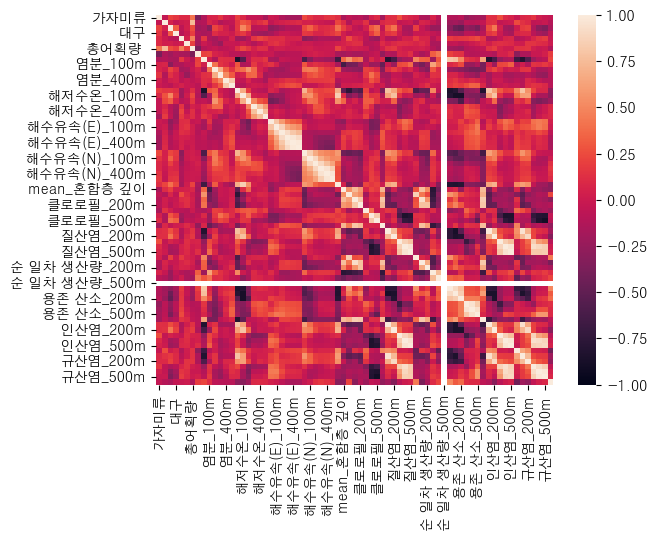

In [ ]:
df_cor = df.corr()
sns.heatmap(df_cor,vmin=-1,annot=False,fmt='.2f')


In [ ]:
fig,ax1= plt.subplots(figsize=(15,7))
ax1.set_xlabel('Year')
ax1.set_ylabel('height')
line1, = ax1.plot(df.index,df[target[0]],label=target[0])
ax2 = ax1.twinx()
ax2.set_ylabel('depth')
line2, = ax2.plot(df.index,df[target[1]],label=target[1],color='orange')
ax2.tick_params(axis='y')
lines = [line1,line2]
ax1.legend(handles=lines,loc='best')

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(target)):
    plt.plot(df.index, df[target[i]], label=target[i])
plt.legend()
plt.show()